# Automating stem cell count

In [1]:
# --------- Mounting Drive and Installing Packages ---------

# Are we using Colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If so, connect to Google account and install needed packages
if IN_COLAB:
    # We mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    ! ls drive/MyDrive/datasets/

    # We install the packages
    ! pip install czifile
    ! python -m pip install "napari[all]"
    ! python -m pip install -U scikit-image
    ! pip install pyclesperanto-prototype
    ! pip install lxml
    ! pip install stardist


In [2]:
# --------- Imports ---------

# General Imports
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns


# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
import skimage.draw
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance

# Clustering Imports
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture




2023-12-19 01:20:42.605933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 01:20:42.606027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 01:20:42.606100: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 01:20:42.615907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
if not IN_COLAB:
  %gui qt

In [4]:
# --------- Opening Images ---------

# Instantiate a Path object
if IN_COLAB:
  czi_file_path = Path(r"drive/MyDrive/datasets/ESTA - Sph1 Z Stack - CTRL SOX2.czi")
else:
  czi_file_path = Path(r"./data/HMGCR/Sph4 plano marca - HMGCR SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object



In [5]:
czi.shape

(1, 1, 3, 1, 1, 2644, 2644, 1)

In [6]:
czi.axes

'BVCTZYX0'

So, according to this, `img` is an array of:
- B = 1, so one block
- V = 1, so one view
- C = 3, so three channels (which makes sense, they are the optic channel, the one indicating the nuclei and the SOX2 channel)
- T = 1, so a single time frame (i.e. no $t$ component)
- Z = 1, so a single $z$ slice (I think that's why it's called “plano” instead of “Stack”)
- Y = 2292, so we have that many pixels in the $y$ direction (height)
- X = 2292, idem (note that we have a square image)
- '0' = 1, indicating that we have a single sample 

I should check the metadata for spacing in this case, but I guess it's the same. I'm interested to see if there's a field for $z$ spacing.

In [7]:
# --------- Getting rid of the extra dimensions ---------
image_squeezed = np.squeeze(img)
image_squeezed.shape

(3, 2644, 2644)

In [8]:
# --------- Separating the channels ---------

# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :]

In [9]:
#@title Using Napari for Visualization

if not IN_COLAB:
  viewer = napari.Viewer()
  viewer.add_image(nuclei_channel, colormap='blue', blending='additive')
  viewer.add_image(stemness_channel, colormap='red', blending='additive')
  viewer.add_image(optic_channel, colormap='gray', blending='additive')
  print(viewer.layers)
  # We never close the napari window and can take a screenshot whenever we like
  nbscreenshot(viewer)

[<Image layer 'nuclei_channel' at 0x7f1f8ff42a10>, <Image layer 'stemness_channel' at 0x7f1f9b7343a0>, <Image layer 'optic_channel' at 0x7f1f8c126470>]


In [9]:
# Z slice to analyze

# z_slice = 3 # we have just one slice now

## Stemness Channel

In [10]:
# --------- Processing the stemness channel ---------

stemness_array = np.copy(stemness_channel)

# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)

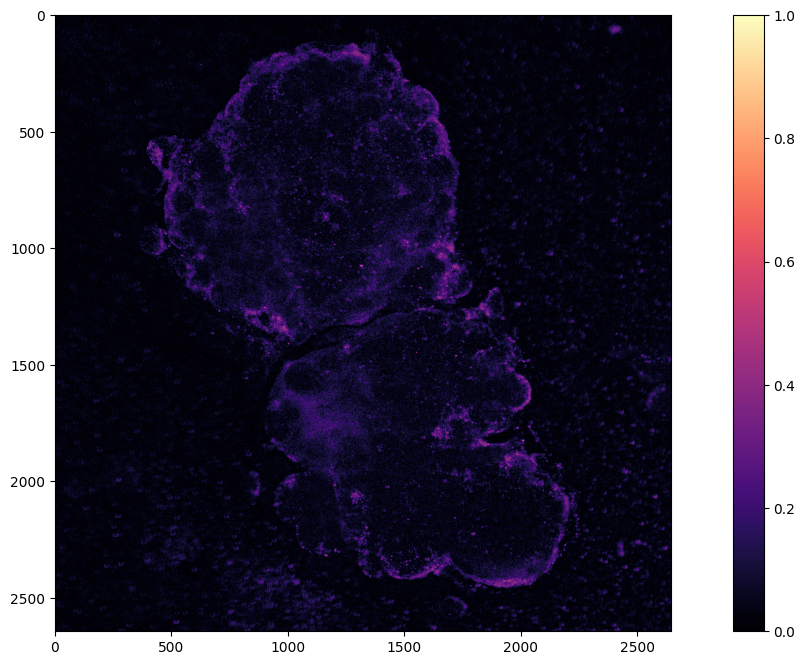

In [11]:
# --------- Visualize the result ---------

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(hdome_adapteq, cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Saving (Local)
# filename = "/slice_4/sox2_processed.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)




plt.show()  # Display the plot

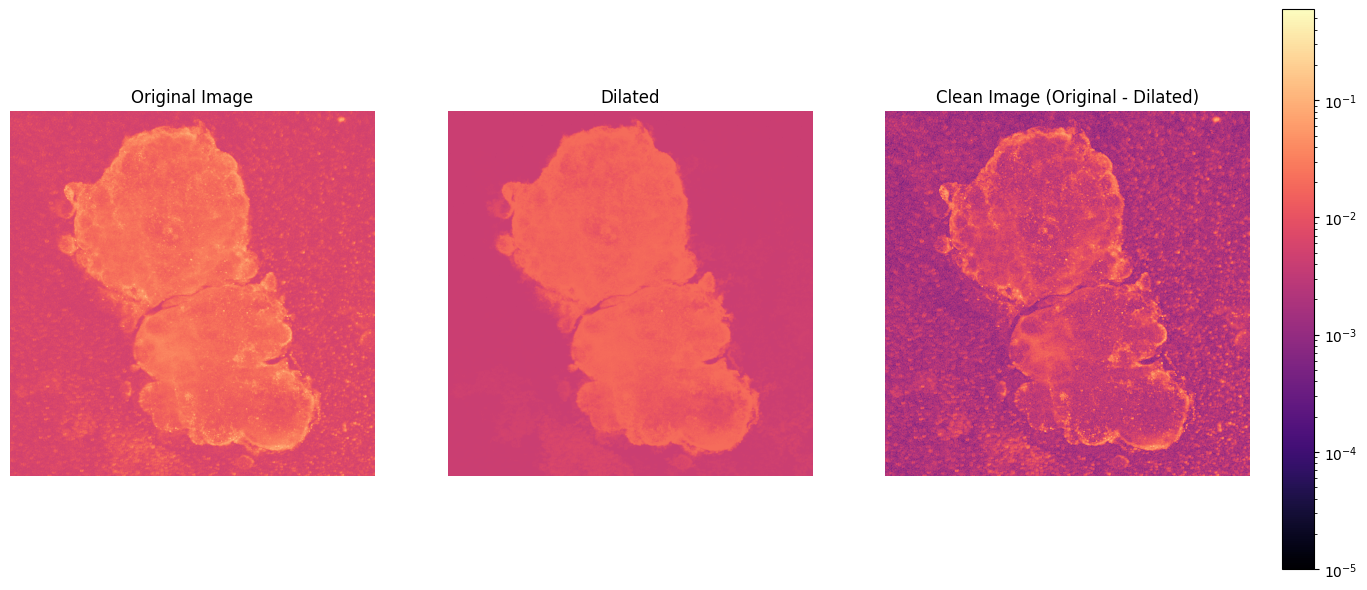

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Your existing code for setting up the figure and axes
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# Define the normalization using LogNorm. You might need to adjust vmin and vmax according to your data range
norm = LogNorm(vmin=stemness_floats_array.min() + 1e-5, vmax=stemness_floats_array.max())

# Plot the images with log normalization
# cmap='bwr'
cmap='magma'

ax0.imshow(stemness_floats_array, cmap=cmap, norm=norm)
ax0.set_title('Original Image')
ax0.axis('off')

ax1.imshow(dilated, cmap=cmap, norm=norm) # , vmin=stemness_floats_array.min(), vmax=stemness_floats_array.max()
ax1.set_title('Dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap=cmap, norm=norm)
ax2.set_title('Clean Image (Original - Dilated)')
ax2.axis('off')

# Add colorbar with log normalization
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # left, bottom, width, height
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')

# fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make space for the colorbar

plt.show()

## Nuclei Channel

In [13]:
# 0. Converting the original image to float (originally it's a 'uint16')
image_3d = np.copy(nuclei_channel)
image_2d = image_3d

image_normalized = image_3d.astype(np.float32) / 65535.0

# 1. Adaptive Histogram Equalization on the 3D image
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized = image_3d_equalized

# 3. Morphological opening to remove small noise
selem = morphology.disk(2)  # using a disk-shaped structuring element of radius 2
image_2d_opened = morphology.opening(image_2d_equalized, selem)
image_2d_opened = morphology.area_closing(image_2d_opened, area_threshold=150)

# 4. Bilateral Filtering (denoising without bluring edges)
image_opened_bilateral = denoise_bilateral(image_2d_opened, sigma_color=0.05, sigma_spatial=15)

# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation on the normalized binary image
labels, details = model.predict_instances(image_opened_bilateral)

# Extract boundaries from the labels
boundaries = find_boundaries(labels)

# ----------------------------------

# Overlay boundaries on the opened, filtered image
overlay = np.copy(image_opened_bilateral)
overlay[boundaries] = np.max(image_opened_bilateral)  # setting the boundary pixels to the maximum value of the image for visualization



Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2023-12-19 01:36:07.109640: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 902955008 exceeds 10% of free system memory.
2023-12-19 01:36:08.251565: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 902955008 exceeds 10% of free system memory.
2023-12-19 01:36:14.155183: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 225738752 exceeds 10% of free system memory.
2023-12-19 01:36:14.822702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 225738752 exceeds 10% of free system memory.
2023-12-19 01:36:15.266717: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 225738752 exceeds 10% of free system memory.


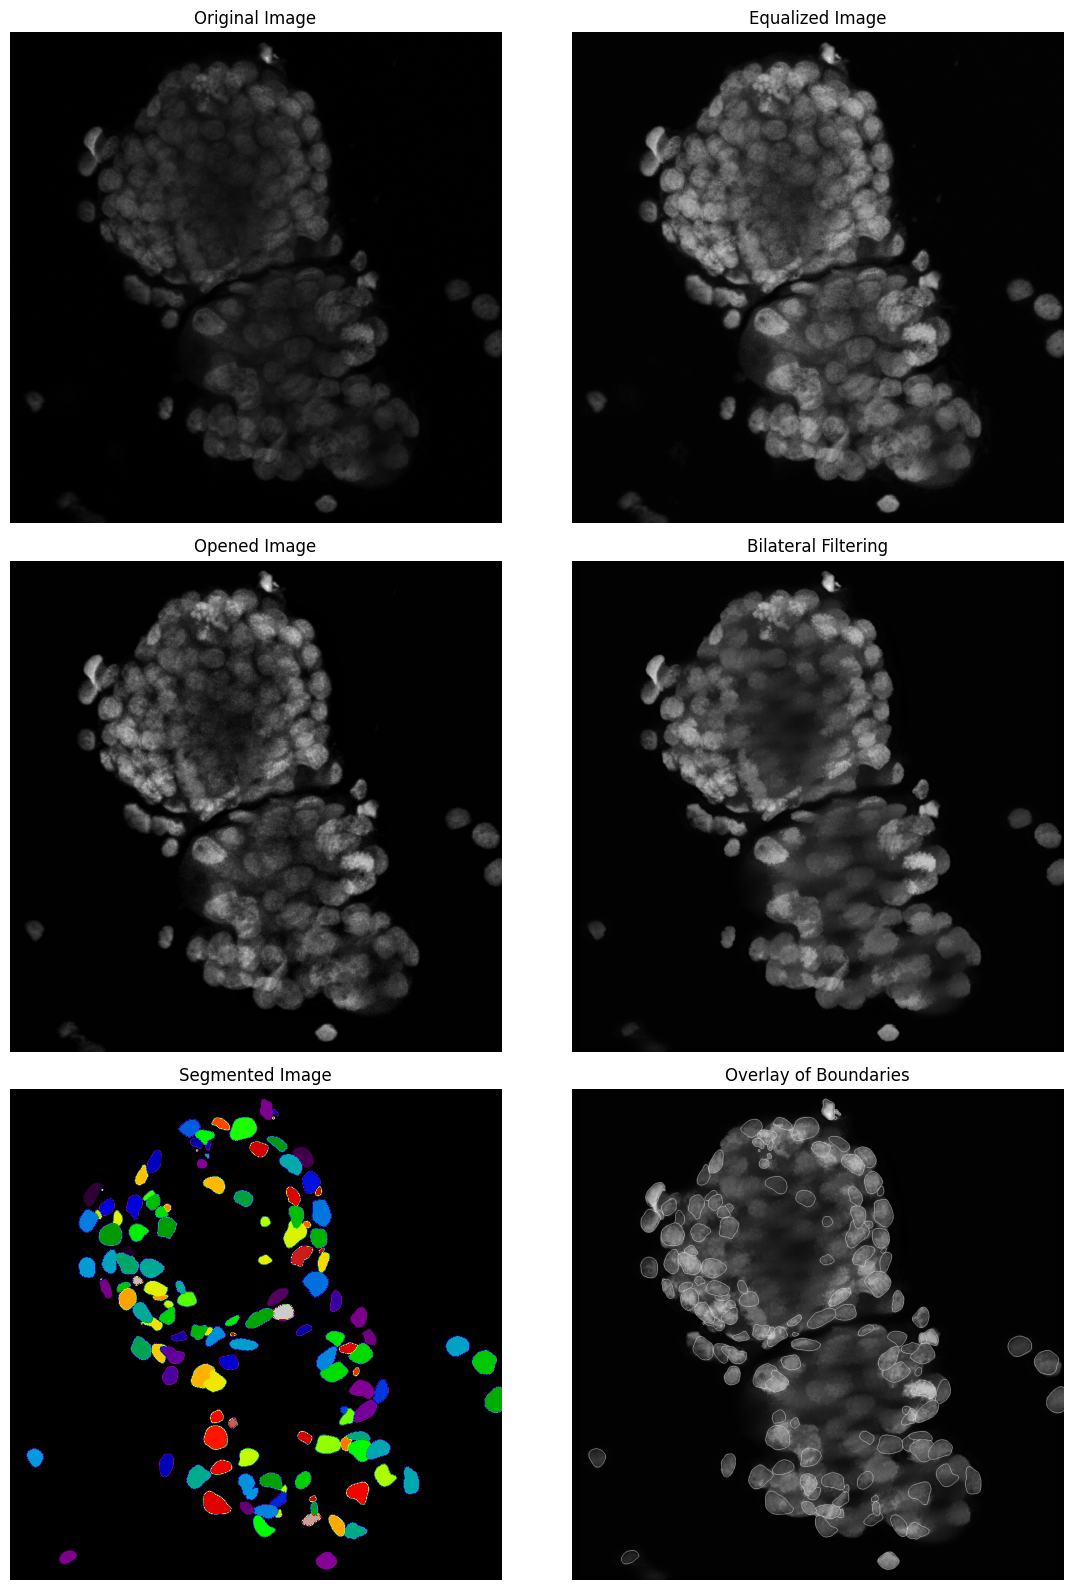

In [14]:
# --------- Visualize the result ---------


# Plotting the original, equalized, opened, and segmented images
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
ax = axes.ravel()

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_equalized, cmap='gray')
ax[1].set_title("Equalized Image")
ax[1].axis('off')

ax[2].imshow(image_2d_opened, cmap='gray')
ax[2].set_title("Opened Image")
ax[2].axis('off')

ax[3].imshow(image_opened_bilateral, cmap='gray')
ax[3].set_title("Bilateral Filtering")
ax[3].axis('off')

ax[4].imshow(labels, cmap='nipy_spectral')
ax[4].set_title("Segmented Image")
ax[4].axis('off')

ax[5].imshow(overlay, cmap='gray')
ax[5].set_title("Overlay of Boundaries")
ax[5].axis('off')

plt.tight_layout()


# # Saving (Local)
# filename = "/slice_4/nuclei_processing.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/sox2_processed.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Generating the DataFrame

In [15]:
# --------- Generation of the DataFrame with geometrical properties of segmented objects ---------

spacing = (1.2364633517553391e-7, 1.2364633517553391e-7)  # in meters for (y, x) dimensions

properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Extract the region properties
regions = regionprops_table(labels, intensity_image=image_opened_bilateral, properties=properties) # , spacing=spacing

# Convert the result to a DataFrame
df = pd.DataFrame(regions)
df


label    area   centroid-0   centroid-1  equivalent_diameter  bbox_area  \
0        1  1881.0  1345.111643  1883.457204            48.938365     2451.0   
1        2  2727.0   874.733040   639.819582            58.924734     3905.0   
2        3  7996.0   568.391446   442.864557           100.900066    13545.0   
3        4  8222.0   368.680005  1581.294576           102.316057    13221.0   
4        5  6865.0  1121.259869  1437.973780            93.492189    11543.0   
..     ...     ...          ...          ...                  ...        ...   
133    134  1962.0  1799.911315  1197.144241            49.980956     2800.0   
134    135    67.0   547.432836   496.313433             9.236182       99.0   
135    136  4408.0  2319.052632  1618.123639            74.916219     7592.0   
136    137  1883.0  1035.753054   684.375465            48.964375     2912.0   
137    138  7820.0  1205.794246  1470.843734            99.783432     9860.0   

     convex_area  filled_area  major_axis_length  minor_axis_length  ...  \
0         1934.0       1881.0          58.764176          41.352076  ...   
1         2787.0       2727.0          69.688179          50.957247  ...   
2         8384.0       7996.0         145.044104          72.482522  ...   
3         8511.0       8222.0         134.619254          79.904447  ...   
4         6979.0       6865.0         138.867709          63.297404  ...   
..           ...          ...                ...                ...  ...   
133       2037.0       1962.0          54.993744          46.067672  ...   
134         76.0         67.0          10.589768           8.397101  ...   
135       4914.0       4408.0         106.304924          54.683328  ...   
136       1997.0       1883.0          53.661165          46.246988  ...   
137       8082.0       7820.0         117.293168          85.732151  ...   

     eccentricity  euler_number    extent  feret_diameter_max  max_intensity  \
0        0.710502             1  0.767442           58.051701       0.561583   
1        0.682144             1  0.698335           73.498299       0.556603   
2        0.866183             1  0.590329          142.695480       0.657723   
3        0.804791             1  0.621889          131.745968       0.537064   
4        0.890077             1  0.594733          141.820309       0.627065   
..            ...           ...       ...                 ...            ...   
133      0.546147             1  0.700714           58.523500       0.438556   
134      0.609293             1  0.676768           11.401754       0.293153   
135      0.857550             1  0.580611          109.110036       0.286358   
136      0.507191             1  0.646635           57.870545       0.411210   
137      0.682461             1  0.793103          119.436175       0.385927   

     mean_intensity min_intensity  orientation   perimeter  solidity  
0          0.451380      0.058579     0.192898  167.296465  0.972596  
1          0.407820      0.220873     1.265032  202.308658  0.978471  
2          0.435048      0.009577    -0.541168  372.617316  0.953721  
3          0.327786      0.010195     0.745334  363.445743  0.966044  
4          0.457659      0.192805    -0.929778  348.918831  0.983665  
..              ...           ...          ...         ...       ...  
133        0.295829      0.118187    -0.210724  169.923882  0.963181  
134        0.156948      0.015352    -1.292232   31.556349  0.881579  
135        0.165406      0.035436    -1.191844  299.019336  0.897029  
136        0.306280      0.159731     1.238218  170.409163  0.942914  
137        0.258687      0.073862    -1.364506  349.078210  0.967582  

[138 rows x 27 columns]

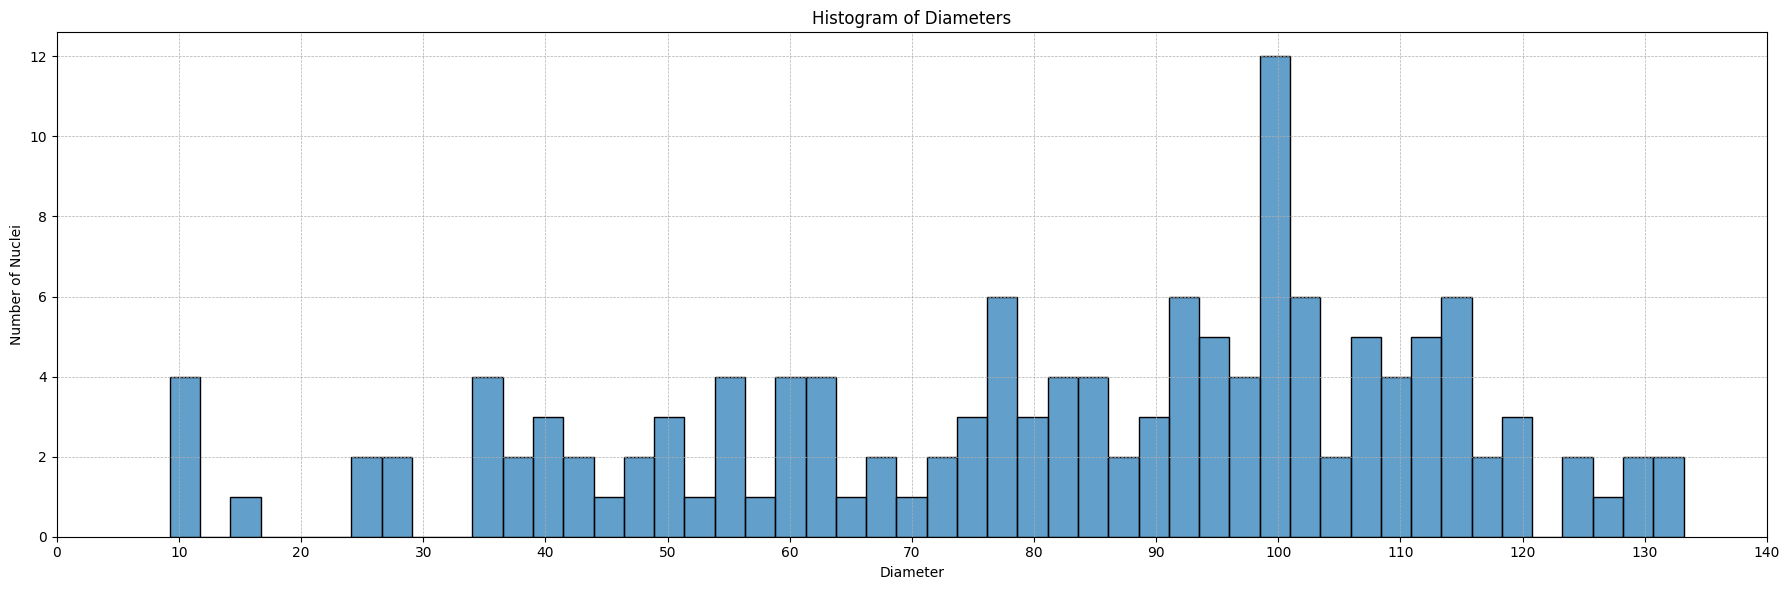

In [16]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='equivalent_diameter', bins=50, element='bars', stat='count', alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Diameters')
plt.xlabel('Diameter')
plt.ylabel('Number of Nuclei')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


Podría cortar tomando sólo los objetos con diámetro > 24.

In [17]:
# --------- Voronoi Teselation ---------

# Convert centroids to integer coordinates for seeding
centroids = df[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Note the coordinate reversal here
vor = Voronoi(points)


In [18]:
# --------- Counting Fluorescence Intensity in each region ---------

sox2_img = hdome
# sox2_img = average_hdome_adapteq

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(sox2_img, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(sox2_img[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity'] = intensity_sums

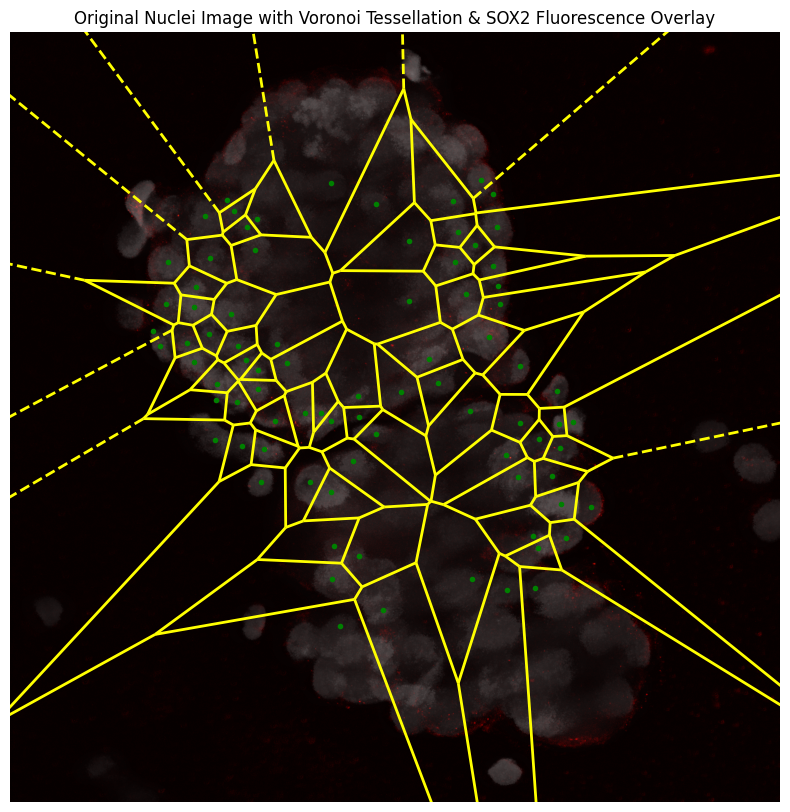

In [19]:
# ========== NEW VORONOI EXCLUDING CELLS OUTSIDE THE SPHEROID ==========

# Assuming df and centroids are already defined

# 1. Calculate center_of_spheroid
center_of_spheroid = df[['centroid-0', 'centroid-1']].mean().values

# 2. Calculate total_spheroid_diameter
df['distance_to_center'] = np.sqrt((df['centroid-0'] - center_of_spheroid[0])**2 + 
                                   (df['centroid-1'] - center_of_spheroid[1])**2)
total_spheroid_diameter = df['distance_to_center'].max()

# 3. Define alpha and add the 'in_spheroid' column
alpha = 0.55
df['in_spheroid'] = df['distance_to_center'] <= alpha * total_spheroid_diameter

# 4. Modify the Voronoi plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Filter centroids for in_spheroid == True
filtered_centroids = df[df['in_spheroid']][['centroid-0', 'centroid-1']].values
vor = Voronoi(np.array([(c, r) for r, c in filtered_centroids]))

# Overlay the Voronoi diagram
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel
ax.imshow(hdome, cmap='hot', alpha=0.6)

# Display the centroids within the spheroid
for (r, c) in filtered_centroids:
    ax.plot(c, r, 'g.')

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()


In [20]:
df['in_spheroid'].value_counts()

in_spheroid
True     83
False    55
Name: count, dtype: int64

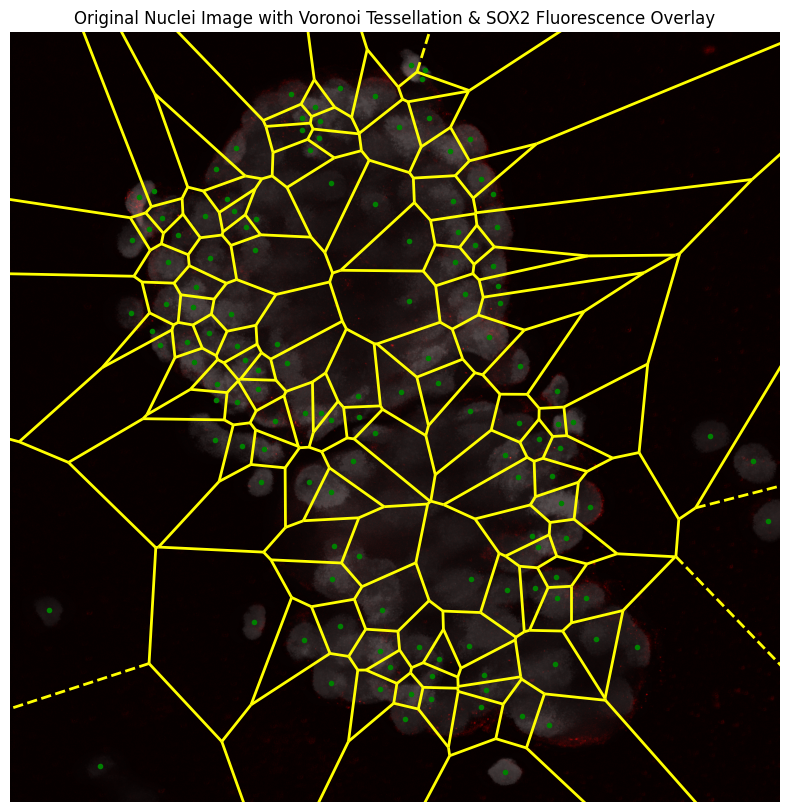

In [21]:
# --------- Regions, Nuclei and SOX2 Overlay ---------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(hdome, cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')


# # Saving (Local)
# filename = "Devel/experimental_images/results/slice_4/nuclei_voronoi_sox2.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

## Stem and Differentiated Cell Clustering

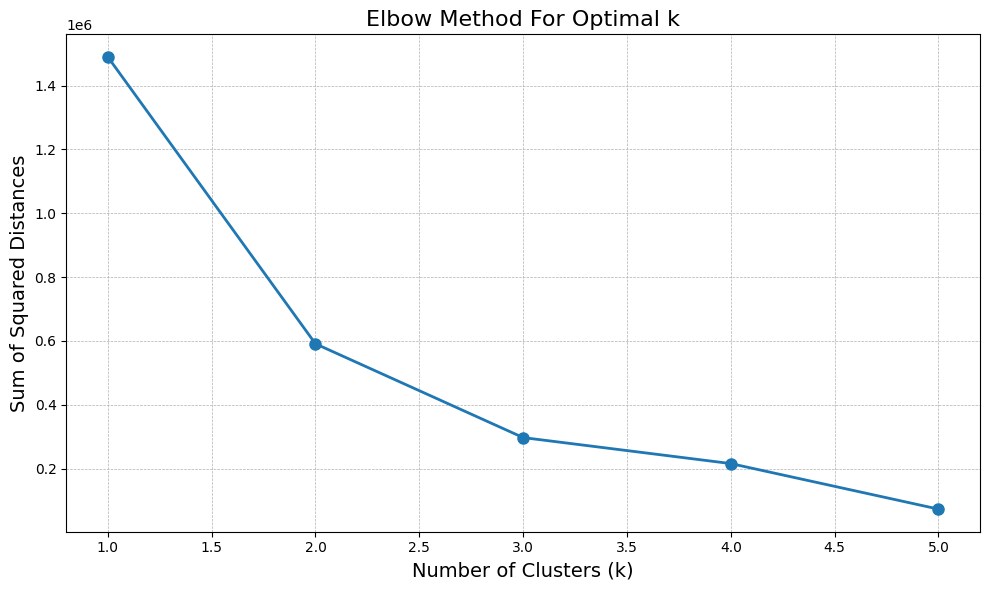

In [22]:
# --------- Elbow plot for cluster number ---------

# Extract fluorescence intensity values from the DataFrame
fluorescence_intensities = df['Fluorescence_Intensity'].loc[df["in_spheroid"]==True].values.reshape(-1, 1)

# Calculate sum of squared distances (SSD) for different values of k
ssd = []
range_n_clusters = range(1, 6)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(fluorescence_intensities)
    ssd.append(kmeans.inertia_)

# Plot the SSD values against k to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Filter out regions with Fluorescence_Intensity <= 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180].copy()  # Use copy() to ensure we're working on a copy

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)


# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels


# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels

# Create a new column in the original dataframe for the mapped labels, initialized to NaN
df['filtered_GMM_stemness'] = np.nan

# Map the GMM_stemness labels back to the original df
df.update(filtered_df['filtered_GMM_stemness'])

# Set the values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity'] > 180, 'filtered_GMM_stemness'] = 1


In [24]:
# ========== NEW CLUSTERING EXCLUDING CELLS OUTSIDE THE SPHEROID ==========

# Filter out regions with Fluorescence_Intensity <= 180 and in_spheroid = True
filtered_df = df[(df['Fluorescence_Intensity'] <= 180) & (df['in_spheroid'])].copy()

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_in_spheroid_GMM_stemness'] = labels

# Create a new column in the original dataframe for the mapped labels, initialized to NaN
df['filtered_in_spheroid_GMM_stemness'] = np.nan

# Map the GMM_stemness labels back to the original df
df.update(filtered_df[['filtered_in_spheroid_GMM_stemness']])

# Set the values to 1 where Fluorescence_Intensity > 180 and in_spheroid = True
df.loc[(df['Fluorescence_Intensity'] > 180) & (df['in_spheroid']), 'filtered_in_spheroid_GMM_stemness'] = 1


In [25]:
df[['label', 'Fluorescence_Intensity', 'filtered_GMM_stemness', 'filtered_in_spheroid_GMM_stemness']].loc[df['Fluorescence_Intensity']>85].loc[df['Fluorescence_Intensity']<95].sort_values(by='Fluorescence_Intensity')

label  Fluorescence_Intensity  filtered_GMM_stemness  \
70      71               85.499687                    0.0   
95      96               86.340414                    0.0   
63      64               86.830259                    0.0   
27      28               87.425315                    0.0   
1        2               89.790585                    1.0   
99     100               90.067796                    1.0   
111    112               91.306371                    1.0   
15      16               91.553994                    1.0   
12      13               93.099855                    1.0   

     filtered_in_spheroid_GMM_stemness  
70                                 0.0  
95                                 NaN  
63                                 NaN  
27                                 NaN  
1                                  0.0  
99                                 0.0  
111                                0.0  
15                                 0.0  
12                                 NaN

In [26]:
# ========== CALCULATING SUMMARY STATISTICS ==========

# the number of one's is the number of CSCs
filtered_GMM_stemness_ones = df['filtered_GMM_stemness'].sum()
filtered_in_spheroid_GMM_stemness_ones = df['filtered_in_spheroid_GMM_stemness'].sum()

# The percentages they represent are
percentage_filtered_GMM_stemness_ones = filtered_GMM_stemness_ones / df.shape[0] * 100
percentage_in_sph_filtered_in_spheroid_GMM_stemness_ones = filtered_in_spheroid_GMM_stemness_ones / df.loc[df['in_spheroid']==True].shape[0] * 100
percentage_total_filtered_in_spheroid_GMM_stemness_ones = filtered_in_spheroid_GMM_stemness_ones / df.shape[0] * 100

# ------ We get the threshold for the fluorescence intensity ------

# Sort the DataFrame by Fluorescence_Intensity
sorted_df = df.sort_values(by='Fluorescence_Intensity')

# Identify the highest Fluorescence_Intensity classified as 0
max_intensity_class_0 = sorted_df[sorted_df['filtered_GMM_stemness'] == 0]['Fluorescence_Intensity'].max()

# Identify the lowest Fluorescence_Intensity classified as 1
min_intensity_class_1 = sorted_df[sorted_df['filtered_GMM_stemness'] == 1]['Fluorescence_Intensity'].min()

# Calculate the average to define the threshold
threshold = (max_intensity_class_0 + min_intensity_class_1) / 2.0

# ------ We get the threshold for the fluorescence intensity filtered by in_spheroid ------

# Sort the DataFrame by Fluorescence_Intensity
sorted_df_in_sph = df.loc[df['in_spheroid']==True].sort_values(by='Fluorescence_Intensity')

# Identify the highest Fluorescence_Intensity classified as 0
max_intensity_class_0_in_sph = sorted_df_in_sph[sorted_df_in_sph['filtered_in_spheroid_GMM_stemness'] == 0]['Fluorescence_Intensity'].max()

# Identify the lowest Fluorescence_Intensity classified as 1
min_intensity_class_1_in_sph = sorted_df_in_sph[sorted_df_in_sph['filtered_in_spheroid_GMM_stemness'] == 1]['Fluorescence_Intensity'].min()

# Calculate the average to define the threshold
threshold_in_sph = (max_intensity_class_0_in_sph + min_intensity_class_1_in_sph) / 2.0



print(f"Number of CSCs according to filtered_GMM_stemness: {filtered_GMM_stemness_ones}")
print(f'They represent a {percentage_filtered_GMM_stemness_ones:.4f}% of the total number of cells')
print(f'The threshold is roughly at a fluorescence intensity of {threshold:.4f}.')
print('--------------------------------------------')
print(f"Number of CSCs according to filtered_in_spheroid_GMM_stemness: {filtered_in_spheroid_GMM_stemness_ones}")
print(f'They represent a {percentage_total_filtered_in_spheroid_GMM_stemness_ones:.4f}% of the total number of cells,')
print(f'and a {percentage_in_sph_filtered_in_spheroid_GMM_stemness_ones:.4f}% of the number of cells in the spheroid.')
print(f'The threshold is roughly at a fluorescence intensity of {threshold_in_sph:.4f}.')


Number of CSCs according to filtered_GMM_stemness: 92.0
They represent a 66.6667% of the total number of cells
The threshold is roughly at a fluorescence intensity of 88.6079.
--------------------------------------------
Number of CSCs according to filtered_in_spheroid_GMM_stemness: 57.0
They represent a 41.3043% of the total number of cells,
and a 68.6747% of the number of cells in the spheroid.
The threshold is roughly at a fluorescence intensity of 103.9772.


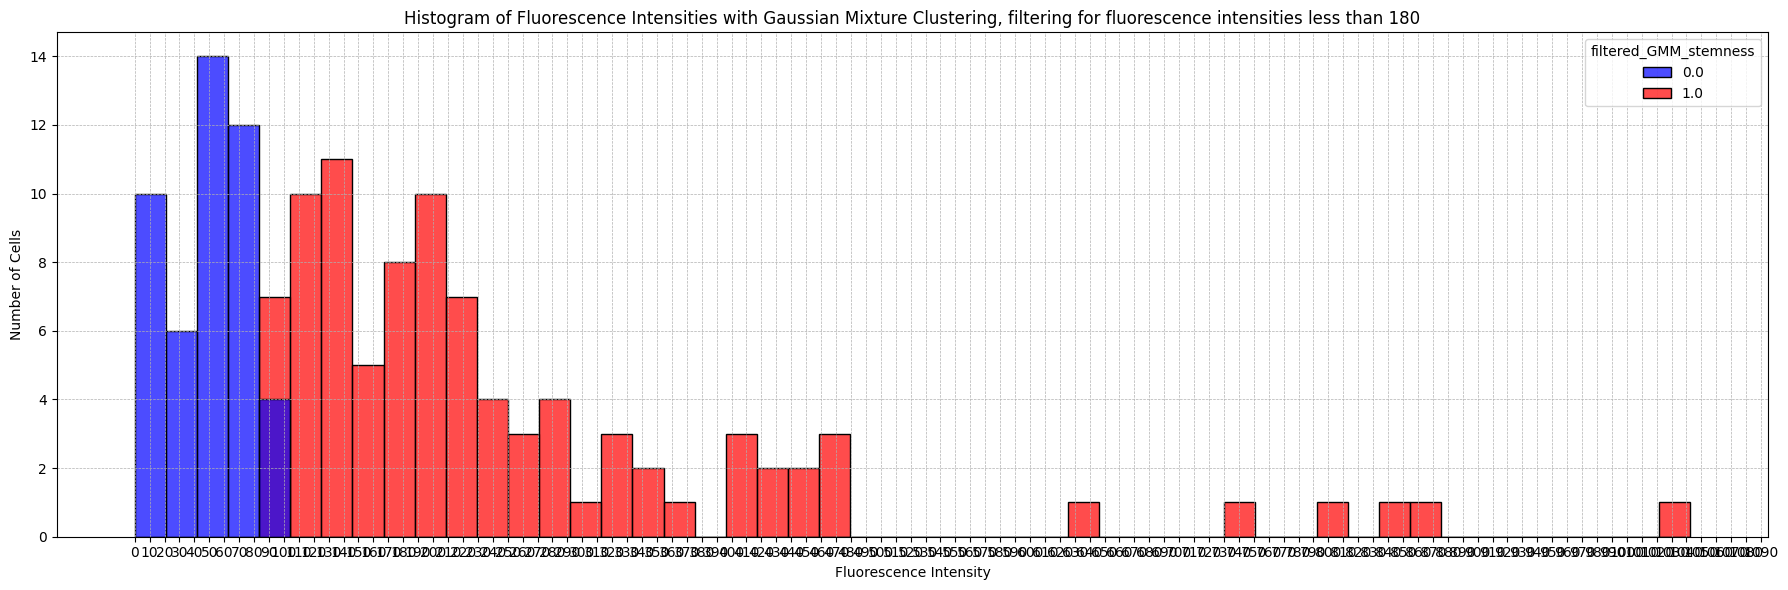

In [27]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='filtered_GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

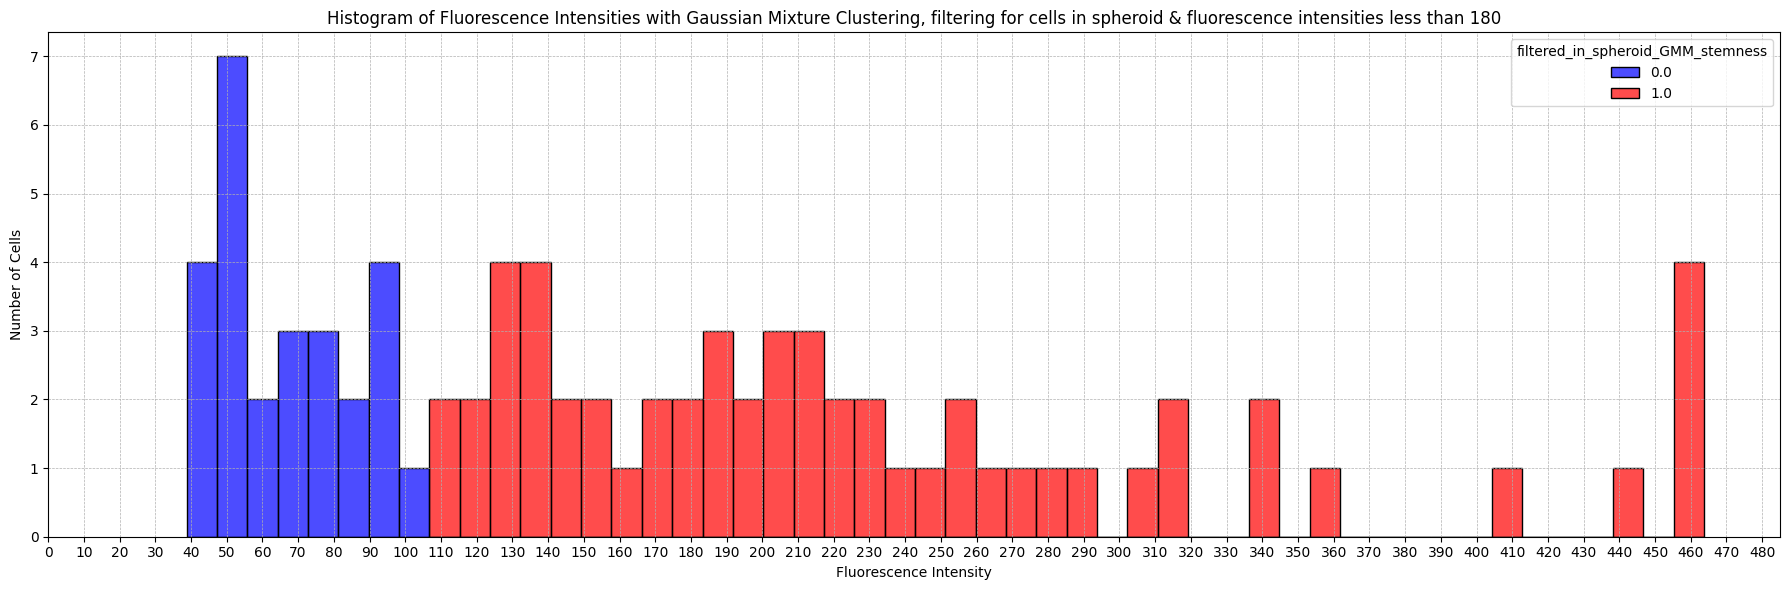

In [29]:
# ========== NEW CLUSTERING EXCLUDING CELLS OUTSIDE THE SPHEROID ==========

plt.figure(figsize=(18, 6))
df_in_spheroid = df.loc[(df['in_spheroid']==True)&(df['Fluorescence_Intensity']<500)].copy()
sns.histplot(df_in_spheroid, x='Fluorescence_Intensity', hue='filtered_in_spheroid_GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for cells in spheroid & fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

In [30]:
df_in_spheroid['filtered_in_spheroid_GMM_stemness'].value_counts()

filtered_in_spheroid_GMM_stemness
1.0    56
0.0    26
Name: count, dtype: int64

In [33]:
# Save the DataFrame to a CSV

# Define the directory path
directory = f"./results/sph3/slice_{z_slice}/"
csv_file_path = os.path.join(directory, f"sph3_slice_{z_slice}.csv") # _in_sph

# # Save the DataFrame to a CSV in the specified directory
# df.to_csv(csv_file_path, index=False)


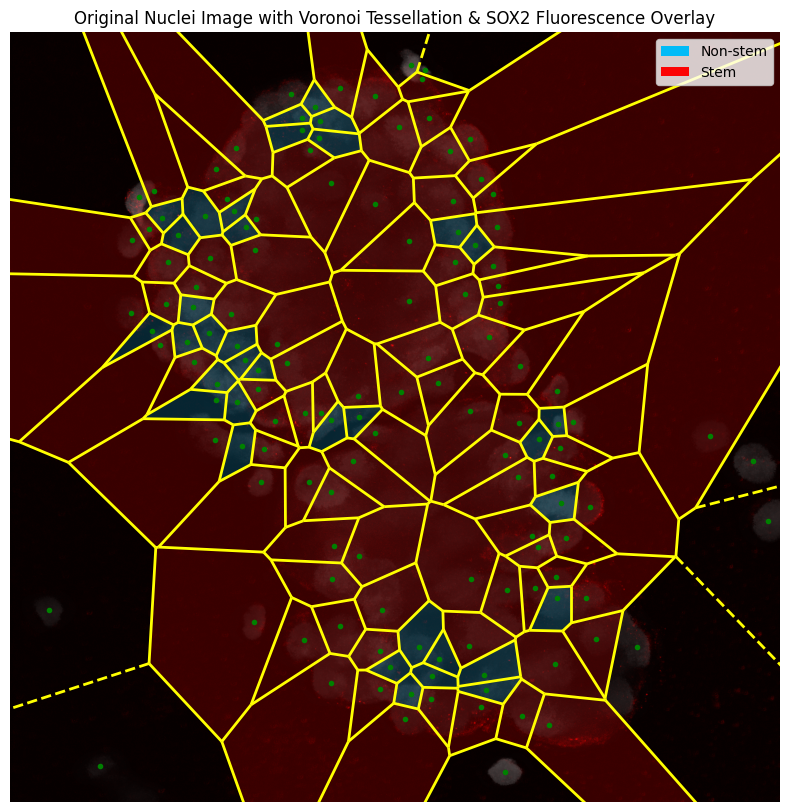

In [31]:


# Define a soft, pastel colormap
pastel_cmap = ListedColormap(['#02bbf7', '#fc0303'])  # modified colors as requested

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay = np.zeros(image_opened_bilateral.shape + (4,), dtype=np.uint8)  # Note the 4 for RGBA

# Fill the Voronoi regions with color based on 'filtered_GMM_stemness'
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral.shape)

        # Get the color based on 'filtered_GMM_stemness'
        stemness_value = df.at[point_idx, 'filtered_GMM_stemness']
        color = pastel_cmap(stemness_value)

        voronoi_overlay[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay, alpha=0.5)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Assume 'hdome[z_slice]' represents your fluorescence channel.
ax.imshow(hdome, cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap(1), label='Stem')]
ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral.shape[1]])
ax.set_ylim([image_opened_bilateral.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()


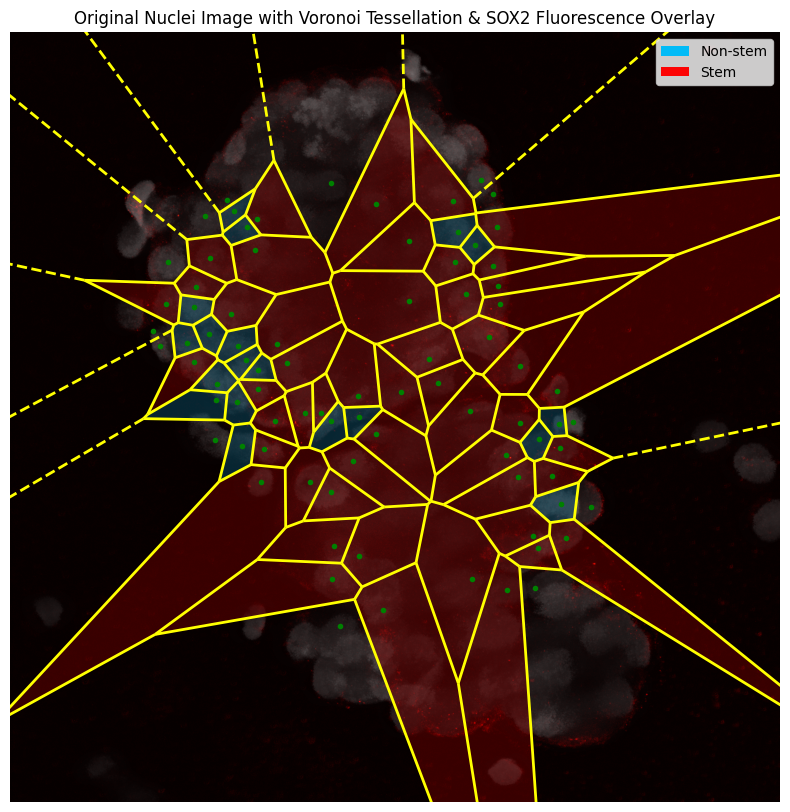

In [32]:
# ============ VERSION WITH THE NEW CLUSTERING ============

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import skimage.draw
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Define a soft, pastel colormap
pastel_cmap = ListedColormap(['#02bbf7', '#fc0303'])  # light blue and light red

# Filter centroids for in_spheroid == True
filtered_centroids = df[df['in_spheroid']][['centroid-0', 'centroid-1']].values

# Using the filtered centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in filtered_centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay = np.zeros(image_opened_bilateral.shape + (4,), dtype=np.uint8)  # 4 for RGBA

# Fill the Voronoi regions with color based on 'filtered_GMM_stemness'
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral.shape)
        
        # Get the corresponding index in the original DataFrame
        original_idx = df[df['in_spheroid']].iloc[point_idx].name
        
        # Get the color based on 'filtered_GMM_stemness'
        stemness_value = df.at[original_idx, 'filtered_GMM_stemness']
        color = pastel_cmap(stemness_value)

        voronoi_overlay[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay, alpha=0.5)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Assume 'hdome[z_slice]' represents your fluorescence channel.
ax.imshow(hdome, cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids within the spheroid
for (r, c) in filtered_centroids:
    ax.plot(c, r, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap(1), label='Stem')]
ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral.shape[1]])
ax.set_ylim([image_opened_bilateral.shape[0], 0])
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()


# Working with the averages

## Average of cleaned images
Vamos a trabajar con el promedio de los cortes 1 a 3 previamente limpiados, y con la segmentación de los núcleos correspondiente al corte 3.

In [ ]:
# # READ the previously saved DataFrame for slice 3

# z_slice = 3

# # Define the directory path
# directory = f"./results/sph3/slice_{z_slice}/"
# csv_file_path = os.path.join(directory, f"sph3_slice_{z_slice}.csv")

# # Read the CSV file into a DataFrame
# df = pd.read_csv(csv_file_path)
# df['slice'] = z_slice
# df['slice'] = df['slice'].astype('category')
# df

In [43]:
# --------- Counting Fluorescence Intensity in each region ---------

# sox2_img = hdome[z_slice]
sox2_img = average_hdome_adapteq

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(sox2_img, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(sox2_img[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity_1st_cleaned_then_averaged'] = intensity_sums

In [48]:
# Save the DataFrame to a CSV

# Define the directory path
directory = f"./results/sph3/slice_{z_slice}/"
csv_file_path = os.path.join(directory, f"sph3_slice_{z_slice}.csv")

# # Save the DataFrame to a CSV in the specified directory
# df.to_csv(csv_file_path, index=False)


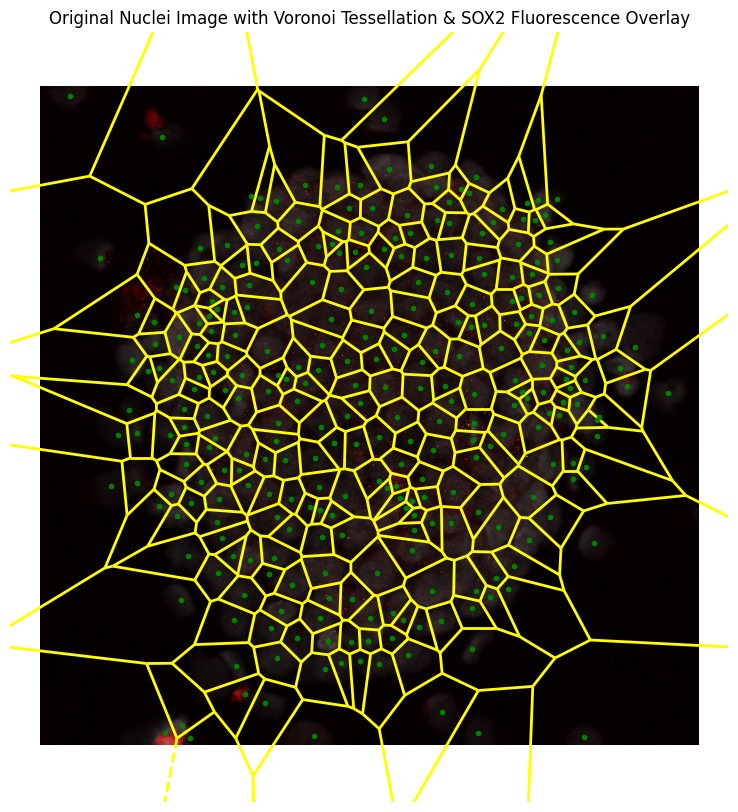

In [45]:
# --------- Regions, Nuclei and SOX2 Overlay ---------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(nuclei_channel[z_slice], cmap='gray') # image_opened_bilateral instead of nuclei_channel

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

# ax.set_xlim([0, labels.shape[1]])
# ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')


# # Saving (Local)
# filename = "Devel/experimental_images/results/slice_4/nuclei_voronoi_sox2.png" # Local path
# plt.savefig(filename)


# # Saving (Colab)
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)
# from google.colab import files
# files.download(filename)



plt.show()

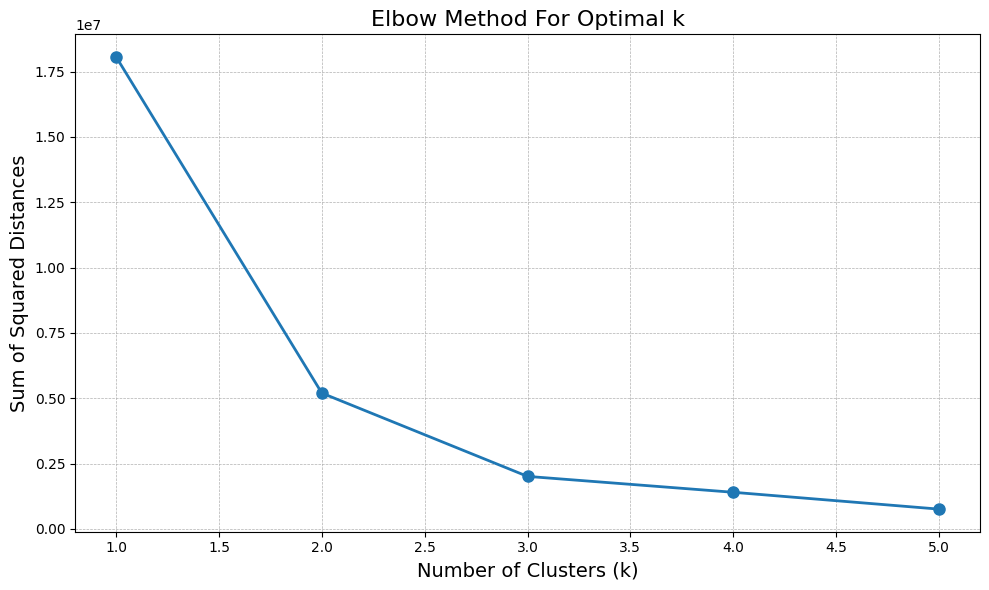

In [50]:
# --------- Elbow plot for cluster number ---------

# Extract fluorescence intensity values from the DataFrame
fluorescence_intensities = df['Fluorescence_Intensity_1st_cleaned_then_averaged'].values.reshape(-1, 1)

# Calculate sum of squared distances (SSD) for different values of k
ssd = []
range_n_clusters = range(1, 6)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(fluorescence_intensities)
    ssd.append(kmeans.inertia_)

# Plot the SSD values against k to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [51]:
# Filter out regions with Fluorescence_Intensity <= 180
filtered_df = df[df['Fluorescence_Intensity_1st_cleaned_then_averaged'] <= 180].copy()  # Use copy() to ensure we're working on a copy

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity_1st_cleaned_then_averaged'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)


# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity_1st_cleaned_then_averaged'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness_from_avg'] = labels


# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness_from_avg'] = labels

# Create a new column in the original dataframe for the mapped labels, initialized to NaN
df['filtered_GMM_stemness_from_avg'] = np.nan

# Map the GMM_stemness labels back to the original df
df.update(filtered_df['filtered_GMM_stemness_from_avg'])

# Set the values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity_1st_cleaned_then_averaged'] > 180, 'filtered_GMM_stemness_from_avg'] = 1

In [52]:
# the number of one's is the number of CSCs
filtered_GMM_stemness_ones = df['filtered_GMM_stemness_from_avg'].sum()
print(f"Number of CSCs according to filtered_GMM_stemness: {filtered_GMM_stemness_ones}")
print(f'They represent a {filtered_GMM_stemness_ones / df.shape[0] * 100:.4f}% of the total number of cells')
print('The threshold is roughly at a fluorescence intensity of 89.')

Number of CSCs according to filtered_GMM_stemness: 187.0
They represent a 63.6054% of the total number of cells
The threshold is roughly at a fluorescence intensity of 89.


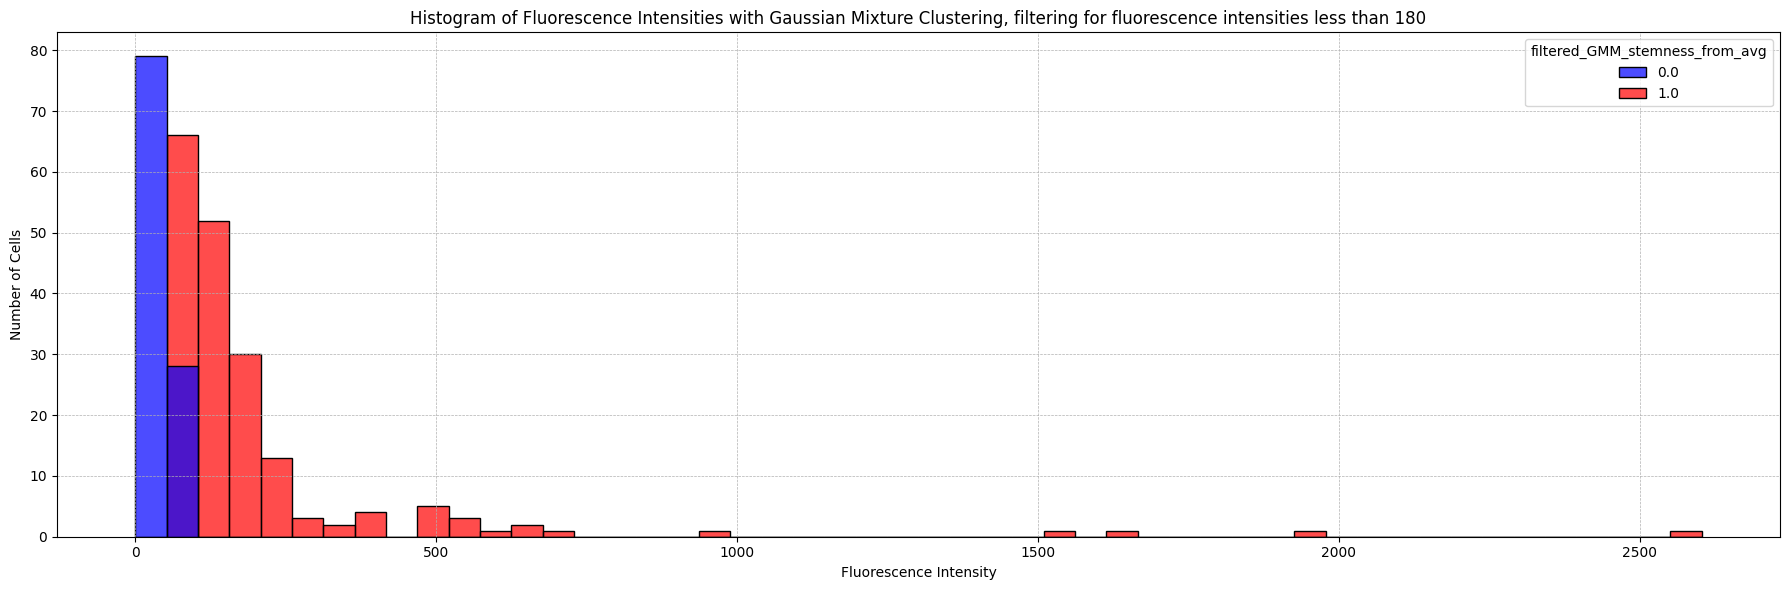

In [53]:
plt.figure(figsize=(18, 6))
sns.histplot(df, x='Fluorescence_Intensity_1st_cleaned_then_averaged', hue='filtered_GMM_stemness_from_avg', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
# plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

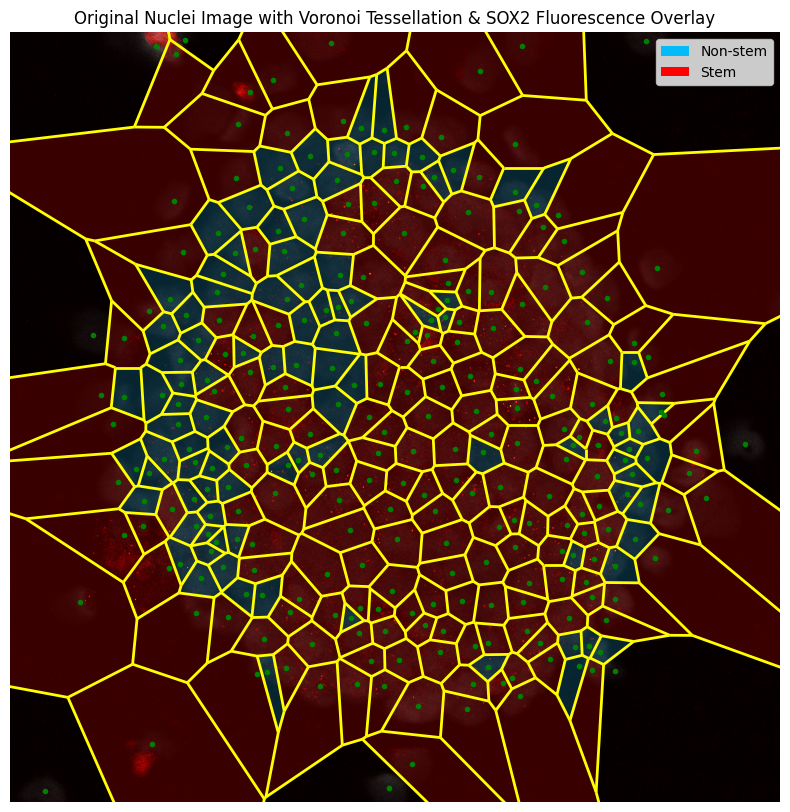

In [54]:


# Define a soft, pastel colormap
pastel_cmap = ListedColormap(['#02bbf7', '#fc0303'])  # modified colors as requested

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(nuclei_channel[z_slice], cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay = np.zeros(nuclei_channel[z_slice].shape + (4,), dtype=np.uint8)  # Note the 4 for RGBA

# Fill the Voronoi regions with color based on 'filtered_GMM_stemness'
for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], nuclei_channel[z_slice].shape)

        # Get the color based on 'filtered_GMM_stemness'
        stemness_value = df.at[point_idx, 'filtered_GMM_stemness_from_avg']
        color = pastel_cmap(stemness_value)

        voronoi_overlay[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay, alpha=0.5)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Assume 'hdome[z_slice]' represents your fluorescence channel.
ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap(1), label='Stem')]
ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, nuclei_channel[z_slice].shape[1]])
ax.set_ylim([nuclei_channel[z_slice].shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')

plt.show()


Number of CSCs according to filtered_GMM_stemness: 182.0
They represent a 61.9048% of the total number of cells
The threshold is roughly at a fluorescence intensity of 89.

## Cleaned average of images